In [1]:
%run '0.0_init_configuration.ipynb'

# Logistic Regression

The objective is to classify the activities the participants performed into one of the six following categories: 

- Walking
- Walking upstairs
- Walking downstairs 
- Sitting
- Standing
- Laying

The following information is provided for each record in the dataset:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
- Triaxial Angular velocity from the gyroscope
- A 561-feature vector with time and frequency domain variables
- The activity label

### Question 1
Import the data and do the following:

- Examine the data types--there are many columns, so it might be wise to use value counts.
- Determine if the floating point values need to be scaled.
- Determine the breakdown of each activity.
- Encode the activity label as an integer.

In [2]:
# Begin Solution

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


The data columns are all floats except for the activita label.

In [3]:
df.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [4]:
df.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

In [5]:
# We use iloc to filter by rows or columns [rows, columns]
df.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [6]:
df.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

In [7]:
df.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.

Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
# We need to conver OV to number 0 and 1 using LabelEncoder
le = LabelEncoder()
df['Activity'] = le.fit_transform(df.Activity)
df['Activity'].sample(5)


2016    4
5456    5
9313    3
143     4
3679    1
Name: Activity, dtype: int64

### Question 2
- Calculate the correlations between the dependent variables.
- Create a histogram of the correlation values.
- Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
features_cols = df.columns[:-1]
corr_values = df[features_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs:
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan

# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack() # conver the matrix to a pair list 
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

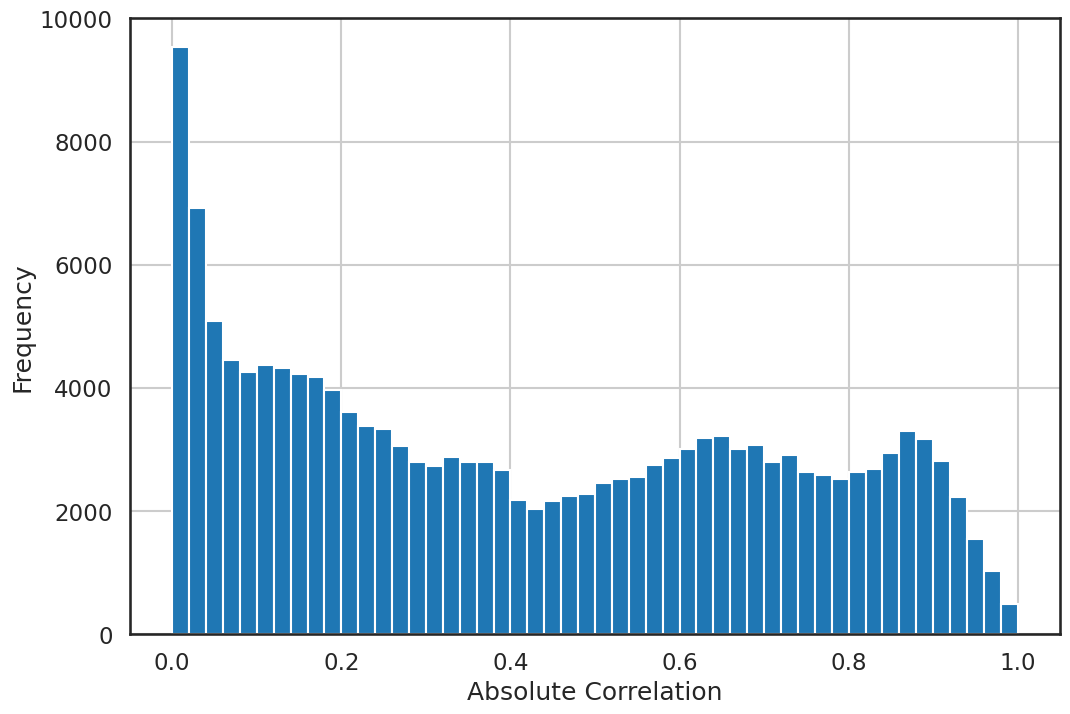

In [10]:
# graph
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12,8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency')

plt.show()

In [11]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
156556,fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
96366,tBodyAccMag-arCoeff()4,tGravityAccMag-arCoeff()4,1.000000,1.000000
109498,tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-sma(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


### Question 3
- Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
- Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.

In [12]:
# Get the split index using StratifiedShuffleSplit method 
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,
                                          test_size=0.3,
                                          random_state = 42)

train_idx, test_idx = next(strat_shuf_split.split(df[features_cols], df.Activity))

#Create the dataframe
X_train = df.loc[train_idx, features_cols]
y_train = df.loc[train_idx, 'Activity']

X_test = df.loc[test_idx, features_cols]
y_test = df.loc[test_idx, 'Activity']

In [13]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

### Question 4
- Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
- Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

solver = liblinear: Adecuado para conjunto de datos pequeños o cuando se unsa regularización L1 (lasso), resuleve problemas de optimización usando método de "descenso de grandiente"

- 'newton-cg': para problemas más grandes y con regularización L2.
- 'lbfgs': similar a 'newton-cg', pero más eficiente para datos grandes.
- 'sag' y 'saga': para grandes cantidades de datos y soportan tanto L1 como L2.
En este caso, liblinear es rápido y funciona bien para conjuntos de datos pequeños o medianos.

- Cs = 10, especifica el número de valores diferentes de la constante de regularización C que evaluara durante la validación cruzada.

- cv = 4 validación cruzada de 4 particiones

In [15]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

# L2 Regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

### Question 5
- Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [16]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                codes = [[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)
coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
242  0.016123 -0.078789  0.061986 -0.731071  0.464251 -0.069518 -0.016175   
94   0.030394  0.062221  0.302152 -0.762586  0.318511  0.115725  0.000000   
545 -0.011598  0.005142  0.244426 -0.183263  0.178892  0.570337 -0.005594   
335  0.004543  0.180258  0.151547 -0.049065 -0.046773  0.217175 -0.088452   
360 -0.026031  0.091810  0.030077  0.077725 -0.018179 -0.268661 -0.003726   
233 -0.046577 -0.059748 -0.283639  0.445114  0.563015 -1.140558 -0.057350   
433 -0.036179 -0.069860 -0.174036  0.710682 -0.780711  0.456565 -0.211871   
416 -0.000062  0.250316  0.308567  0.050139  0.465617  0.194790 -0.006525   
342  0.011490 -0.080072  0.077592 -0.037283 -0.168704 -0.078234  0.000000   
116  0.218578 -0.285162  0.074299  0.273388 -0.037486 -0.147463  0.745363   

                                                             l2            \
            1         2         3         4         5         0         1   
242  0.000000  0.000000 -1.214261  1.223491 -0.450342  0.040247 -0.381342   
94   0.000000  0.000000 -1.138279  0.026668  0.182250  0.052901 -0.631200   
545  0.000000  0.000000  0.000000  0.000000  0.663003 -0.036330 -0.434933   
335  0.000000  0.000000  0.000000  0.521176  0.396718 -0.012036  0.306250   
360  0.000000  0.000000  0.000000  0.007646 -0.249324 -0.062301  0.224560   
233  0.000000  0.000000  0.450878  1.415322 -2.150495 -0.082521  0.127314   
433  0.000000  0.000000  1.092584 -1.005841  0.982868 -0.054249  0.210426   
416  0.357681  0.805545  0.000000  0.491765  0.396684 -0.020668  0.698486   
342  0.000000  0.000000  0.000000  0.000000 -0.178173  0.017275 -0.097111   
116 -0.115958  0.000000  0.000000  0.000000 -1.162100  0.380329 -0.360374   

                                             
            2         3         4         5  
242  0.075471 -2.144274  0.939077 -0.270598  
94   0.522697 -2.433145  0.892178  0.339069  
545  0.276007 -0.717254  0.295751  1.369807  
335  0.160678 -0.235891 -0.278855  0.806314  
360  0.019602  0.443771 -0.080545 -0.568072  
233 -0.434103  1.294952  1.165664 -2.338838  
433 -0.204658  1.907855 -1.468300  0.548891  
416  0.447711  0.102268  1.187214  0.436348  
342  0.076606 -0.044348 -0.301250 -0.344229  
116  0.093405  0.841307 -0.063978 -0.195028

Prepare six separate plots for each of the multi-class coefficients.

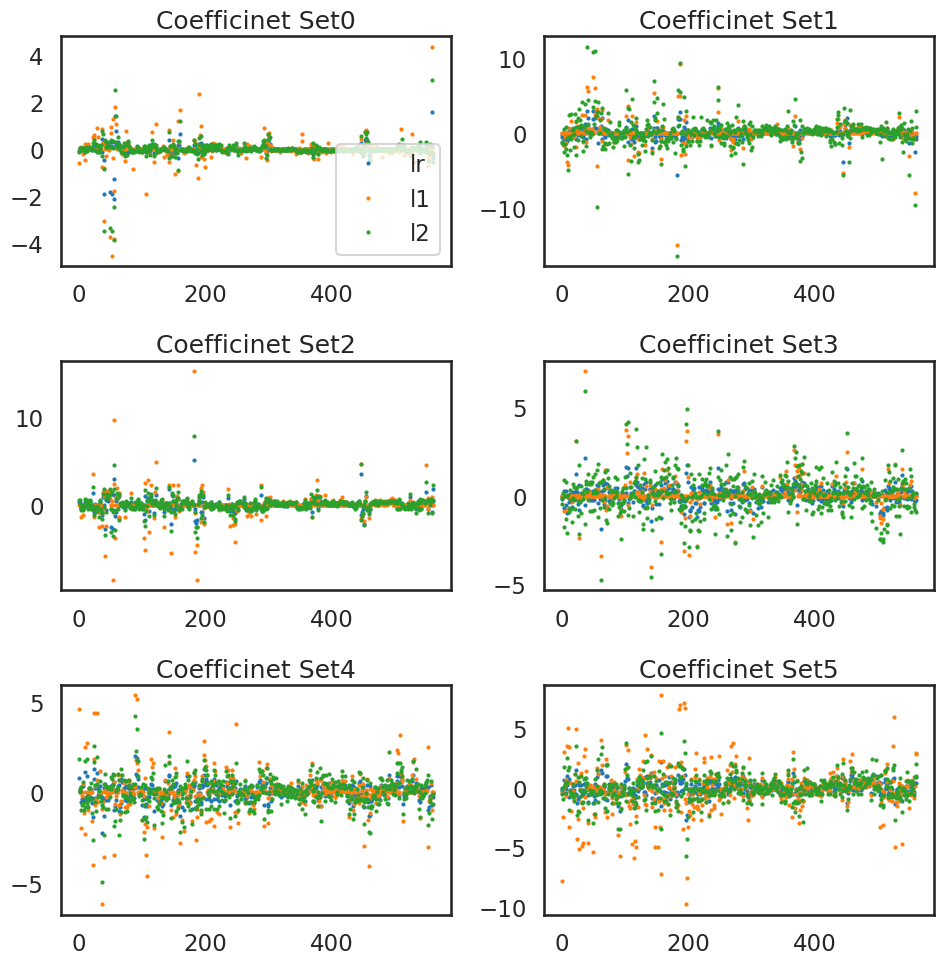

In [17]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker = 'o', ls='', ms=2.0, ax=ax, legend=False)

    if ax is axList[0]:
        ax.legend(loc=4)
    
    ax.set(title='Coefficinet Set' + str(loc))

plt.tight_layout()
plt.show()

### Question 6
- Predict and store the class for each model.
- Store the probability for the predicted class for each model.

In [18]:
# Predict the class and the probability for ech
y_pred = list()
y_prob = list()

coeff_label = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_label, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))

y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [19]:
y_prob.head()

,lr,l1,l2
0,0.998939,0.999001,0.999757
1,0.988165,0.999413,0.999489
2,0.987592,0.995602,0.999657
3,0.981381,0.999168,0.994339
4,0.998277,0.999919,0.999997


### Question 7
For each model, calculate the following error metrics:

- Accuracy
- Precision
- Recall
- F-score
- Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [22]:
metrics = list()
cm = dict()

for lab in coeff_labels:
    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')

    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])

    #ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
                        label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]),
                        average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                              'fscore':fscore, 'accuracy': accuracy,
                              'auc':auc},
                              name=lab))
    
metrics = pd.concat(metrics, axis=1)

metrics

,lr,l1,l2
precision,0.984144,0.983514,0.983824
recall,0.984142,0.983495,0.983819
fscore,0.984143,0.983492,0.983819
accuracy,0.984142,0.983495,0.983819
auc,0.990384,0.989949,0.990165


### Question 8

- Display or plot the confusion matrix for each model.

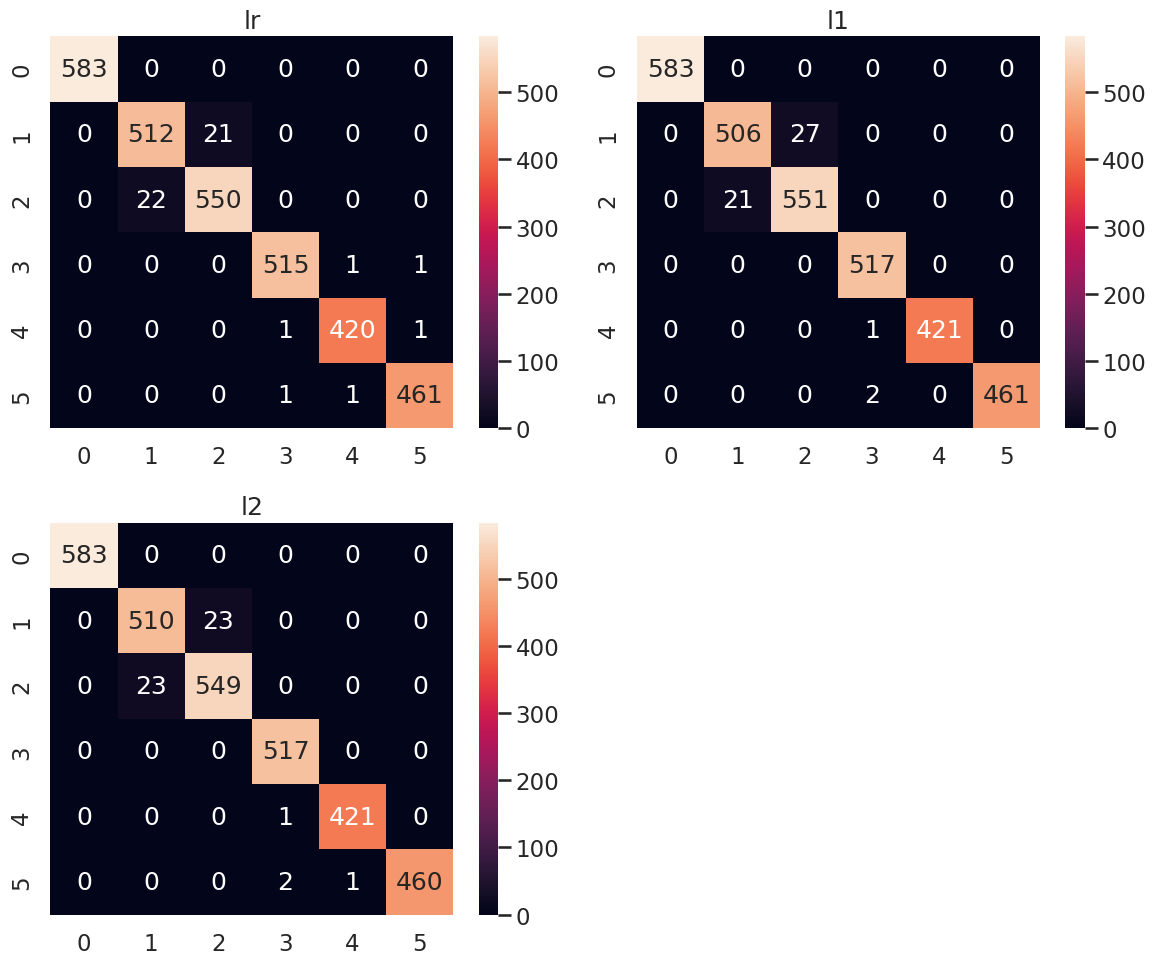

In [23]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12,10)

axList[-1].axis('off')

for ax, lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)

plt.tight_layout()
plt.show()